# Module D — Reciprocal Indexing Validation

Validate the k+G tables emitted by `mpb2d-validation -- reciprocal-data` for square and triangular lattices (resolution 32, mesh_size 4, three samples per symmetry-leg). Each step below ties back to the Module D checklist: index remapping, |k+G|² histograms, aliasing/property checks, and inspection of constant-mode clamps.

In [1]:
from __future__ import annotations
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use("tableau-colorblind10")
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.dpi"] = 130
ARTIFACT_DIR = Path("artifacts/reciprocal_data")

In [2]:
def load_reports(directory: Path) -> dict[str, dict]:
    reports = {}
    for path in sorted(directory.glob("reciprocal_*_res32_mesh4.json")):
        key = path.stem.replace("reciprocal_", "")
        with path.open() as handle:
            reports[key] = json.load(handle)
    if not reports:
        raise FileNotFoundError(f"No reciprocal artifacts found in {directory}")
    return reports

reports = load_reports(ARTIFACT_DIR)
list(reports.keys())

['square_res32_mesh4', 'triangular_res32_mesh4']

In [3]:
TAU = 2 * np.pi
index_checks: list[dict[str, object]] = []
for name, report in reports.items():
    lx, ly = report["grid"]["extent"]
    bad = 0
    for entry in report["index_map"]:
        gx_expected = TAU * entry["mx"] / lx
        gy_expected = TAU * entry["my"] / ly
        if (
            abs(entry["gx"] - gx_expected) > 1e-9
            or abs(entry["gy"] - gy_expected) > 1e-9
        ):
            bad += 1
    index_checks.append(
        {
            "lattice": name,
            "bad_entries": bad,
            "total_entries": len(report["index_map"]),
            "reuse_ready": bad == 0,
        }
    )
pd.DataFrame(index_checks)

,lattice,bad_entries,total_entries,reuse_ready
0,square_res32_mesh4,0,1024,True
1,triangular_res32_mesh4,0,1024,True


In [4]:
def summarize_samples(lattice_name: str, report: dict) -> list[dict[str, object]]:
    rows: list[dict[str, object]] = []
    total_pts = report["grid"]["shape"][0] * report["grid"]["shape"][1]
    for idx, sample in enumerate(report["samples"]):
        stats = sample["magnitude_stats"]
        clamp_fraction = float(np.mean(sample["clamp_mask"]))
        rows.append(
            {
                "lattice": lattice_name,
                "sample_idx": idx,
                "label": sample["label"],
                "segment": sample["segment"],
                "min_|k+G|^2": stats["min"],
                "max_|k+G|^2": stats["max"],
                "mean_|k+G|^2": stats["mean"],
                "clamp_fraction": clamp_fraction,
                "num_clamped": clamp_fraction * total_pts,
                "aliasing_ok": sample["aliasing_ok"],
                "non_negative": sample["non_negative"],
            }
        )
    return rows

summary_rows: list[dict[str, object]] = []
for lattice_name, report in reports.items():
    summary_rows.extend(summarize_samples(lattice_name, report))
summary_df = pd.DataFrame(summary_rows)
summary_df

,lattice,sample_idx,label,segment,min_|k+G|^2,max_|k+G|^2,mean_|k+G|^2,clamp_fraction,num_clamped,aliasing_ok,non_negative
0,square_res32_mesh4,0,Γ,Γ→X,1.000000e-09,20212.949813,6750.809410,0.000977,1.0,True,True
1,square_res32_mesh4,1,Γ→X midpoint,Γ→X,2.467401e+00,20531.244555,6763.146416,0.000000,0.0,True,True
2,square_res32_mesh4,2,X,Γ→X,9.869604e+00,20854.474100,6780.418224,0.000000,0.0,True,True
3,square_res32_mesh4,3,X→M midpoint,X→M,1.233701e+01,21172.768841,6792.755229,0.000000,0.0,True,True
4,square_res32_mesh4,4,M,X→M,1.973921e+01,21495.998386,6810.027037,0.000000,0.0,True,True
5,square_res32_mesh4,5,M→Γ midpoint,M→Γ,4.934802e+00,20849.539297,6775.483421,0.000000,0.0,True,True
6,square_res32_mesh4,6,Γ,M→Γ,1.000000e-09,20212.949813,6750.809410,0.000977,1.0,True,True
7,triangular_res32_mesh4,0,Γ,Γ→M,1.000000e-09,20212.949813,6750.809410,0.000977,1.0,True,True
8,triangular_res32_mesh4,1,Γ→M midpoint,Γ→M,3.289868e+00,20714.410023,6769.667102,0.000000,0.0,True,True
9,triangular_res32_mesh4,2,M,Γ→M,1.315947e+01,21222.449968,6795.104529,0.000000,0.0,True,True


In [5]:
agg_checks = (
    summary_df.groupby("lattice")[["aliasing_ok", "non_negative"]].all()
    .rename(columns={"aliasing_ok": "aliasing_ok_for_all", "non_negative": "non_negative_for_all"})
)
clamp_stats = summary_df.groupby("lattice")["clamp_fraction"].agg(["max", "mean"])
display(agg_checks)
display(clamp_stats)
if not agg_checks.values.all():
    raise AssertionError("Reciprocal validation failed checks")
print("All aliasing/non-negativity checks passed.")

,aliasing_ok_for_all,non_negative_for_all
lattice,,
square_res32_mesh4,True,True
triangular_res32_mesh4,True,True


,max,mean
lattice,,
square_res32_mesh4,0.000977,0.000279
triangular_res32_mesh4,0.000977,0.000279


All aliasing/non-negativity checks passed.


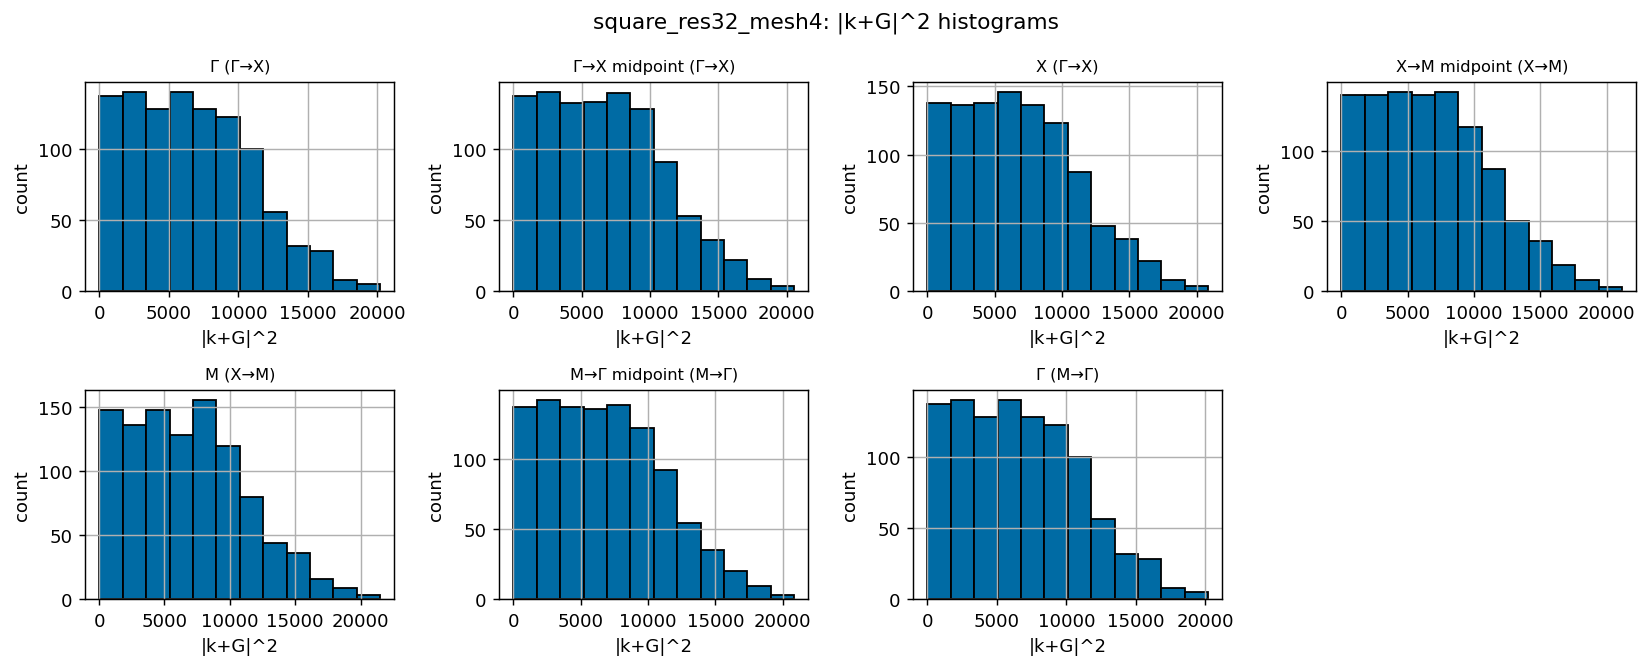

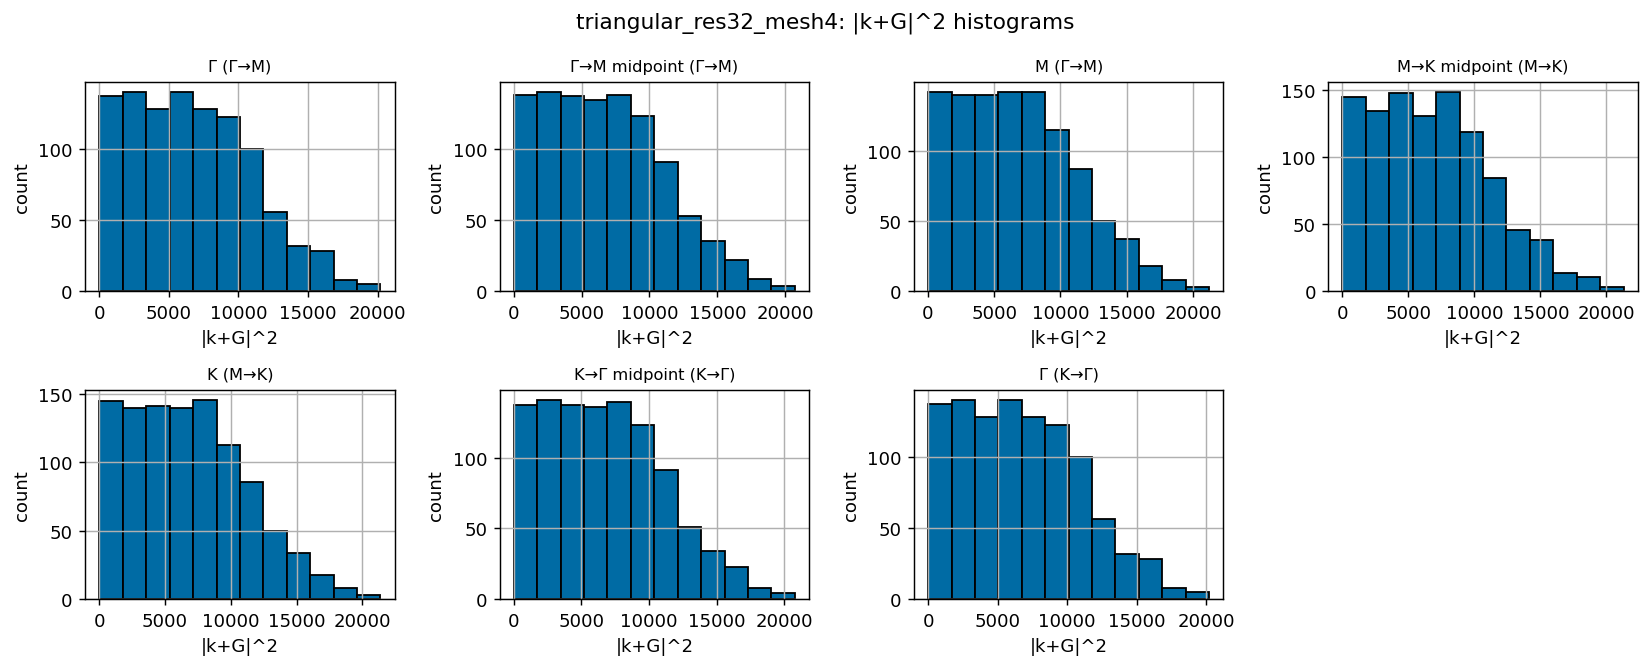

In [6]:
def plot_histograms(report: dict, title: str) -> None:
    samples = report["samples"]
    rows, cols = 2, 4
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.2, rows * 2.6), sharey=False)
    axes_flat = axes.flatten()
    for sample, ax in zip(samples, axes_flat):
        bins = sample["histogram"]["bins"]
        if not bins:
            ax.set_visible(False)
            continue
        lefts = [b["min"] for b in bins]
        widths = [b["max"] - b["min"] for b in bins]
        counts = [b["count"] for b in bins]
        ax.bar(lefts, counts, width=widths, align="edge", edgecolor="black")
        ax.set_title(f"{sample['label']} ({sample['segment']})", fontsize=9)
        ax.set_xlabel("|k+G|^2")
        ax.set_ylabel("count")
    for ax in axes_flat[len(samples):]:
        ax.set_visible(False)
    fig.suptitle(title)
    fig.tight_layout()

for lattice_name, report in reports.items():
    plot_histograms(report, f"{lattice_name}: |k+G|^2 histograms")

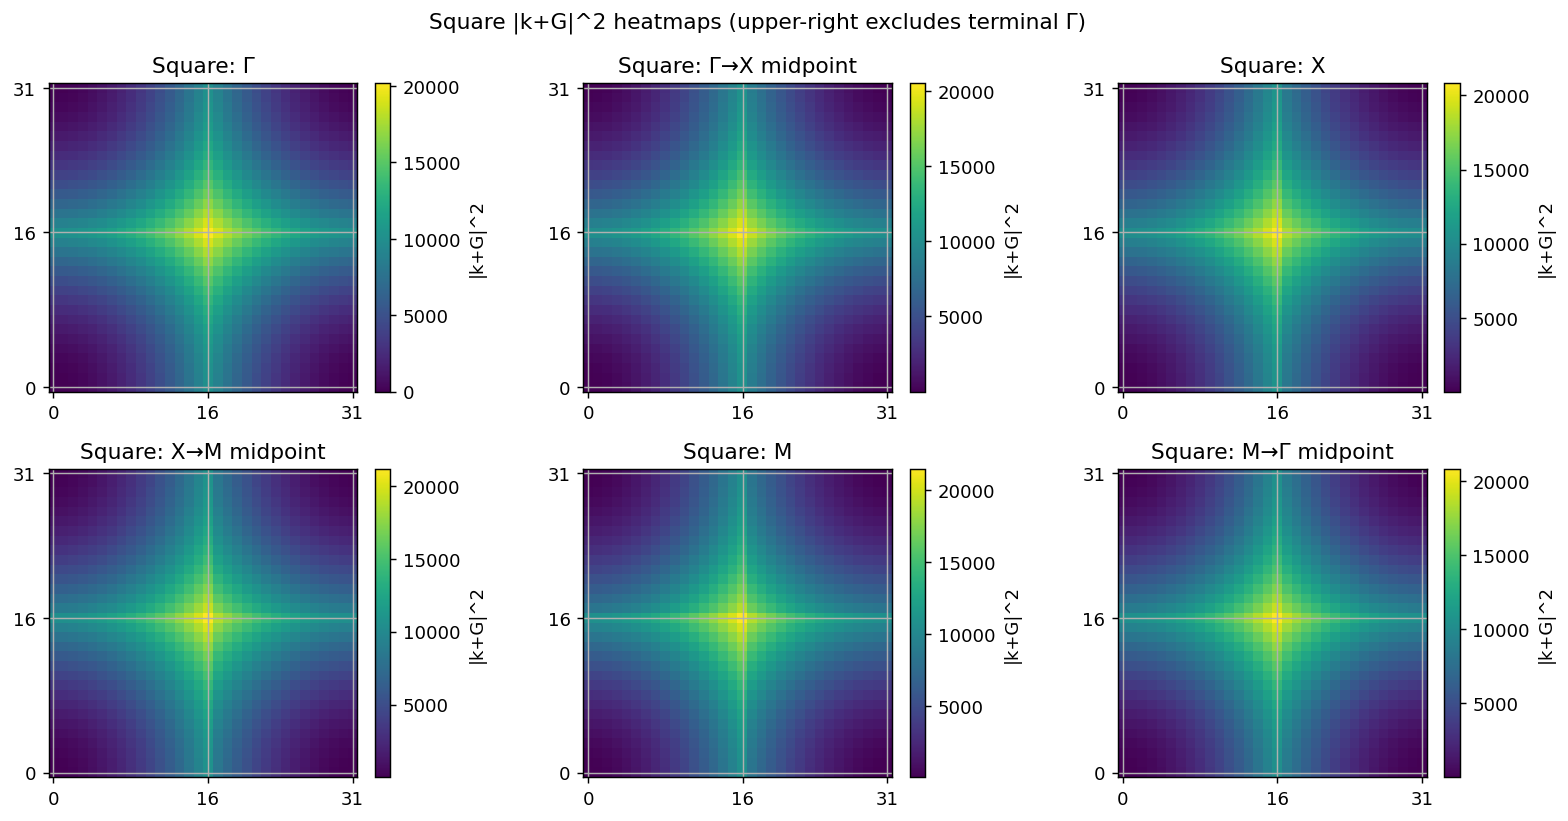

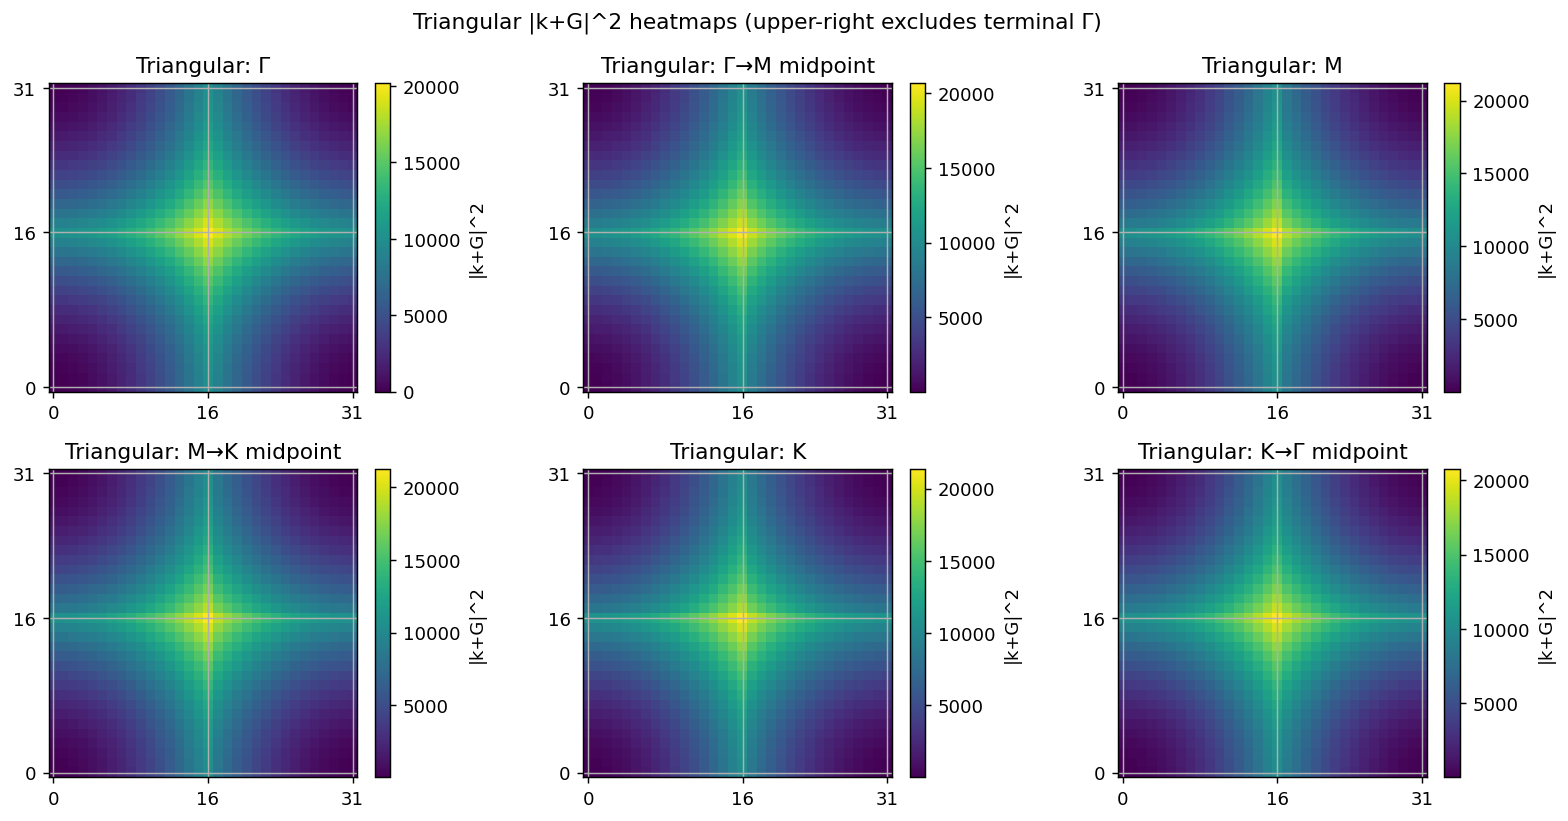

In [9]:
def plot_heatmaps(report: dict, lattice_label: str) -> None:
    nx, ny = report["grid"]["shape"]
    samples = report["samples"][:-1]  # drop the final Γ that closes the loop
    rows, cols = 2, 3
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4.2, rows * 3.2))
    axes_flat = axes.flatten()
    for sample, ax in zip(samples, axes_flat):
        field = np.array(sample["k_plus_g_sq"]).reshape(ny, nx)
        im = ax.imshow(field, origin="lower", cmap="viridis")
        ax.set_title(f"{lattice_label}: {sample['label']}")
        ax.set_xticks([0, nx // 2, nx - 1])
        ax.set_yticks([0, ny // 2, ny - 1])
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="|k+G|^2")
    for ax in axes_flat[len(samples):]:
        ax.set_visible(False)
    fig.suptitle(f"{lattice_label} |k+G|^2 heatmaps (upper-right excludes terminal Γ)")
    fig.tight_layout()

plot_heatmaps(reports["square_res32_mesh4"], "Square")
plot_heatmaps(reports["triangular_res32_mesh4"], "Triangular")

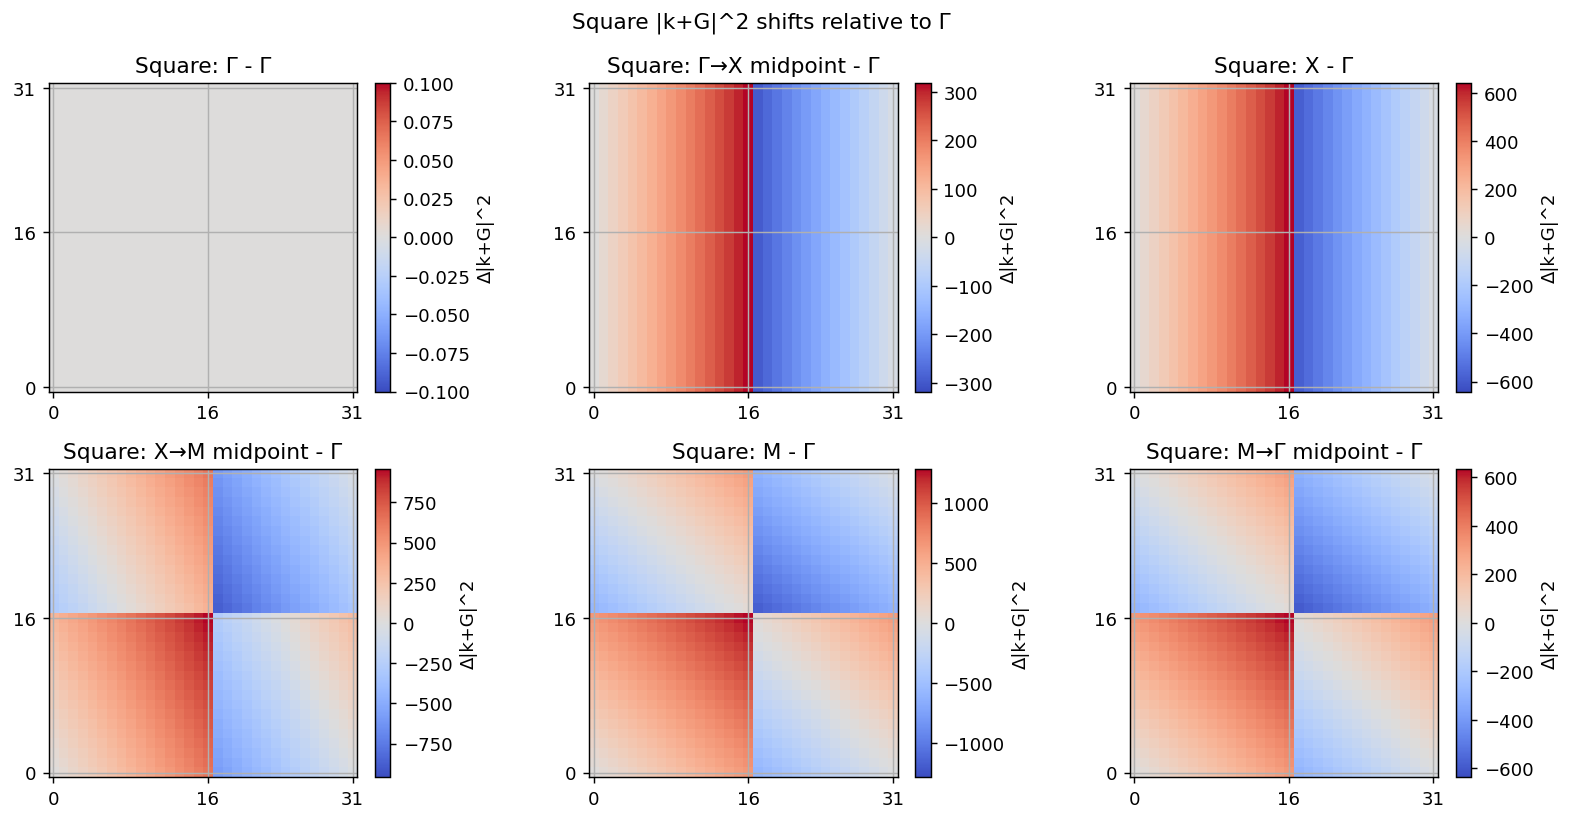

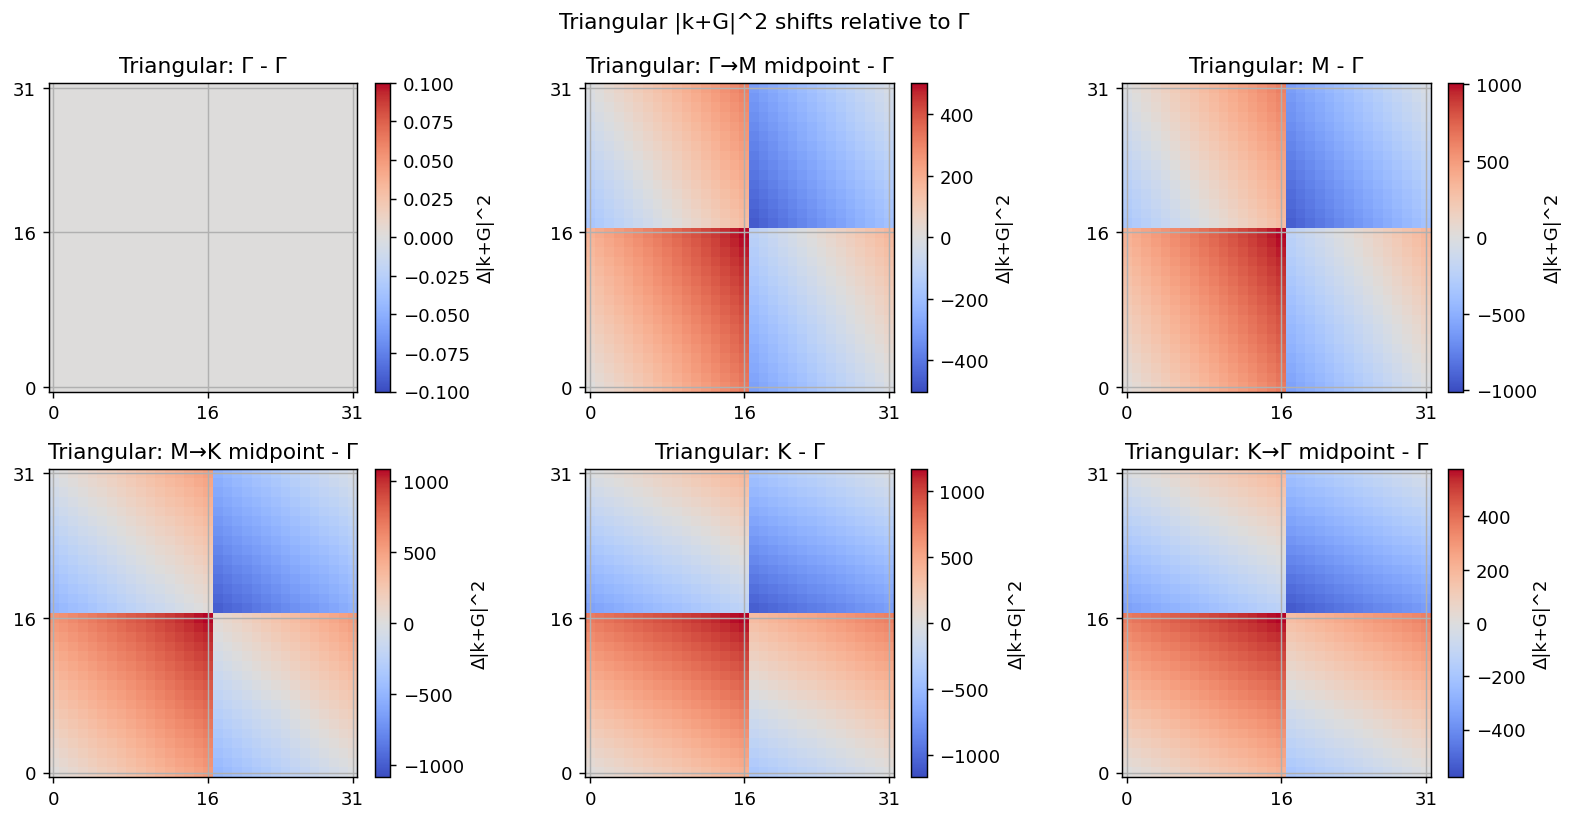

In [11]:
def plot_relative_heatmaps(report: dict, lattice_label: str) -> None:
    nx, ny = report["grid"]["shape"]
    samples = report["samples"][:-1]
    gamma_field = np.array(samples[0]["k_plus_g_sq"]).reshape(ny, nx)
    rows, cols = 2, 3
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4.2, rows * 3.2))
    axes_flat = axes.flatten()
    for sample, ax in zip(samples, axes_flat):
        field = np.array(sample["k_plus_g_sq"]).reshape(ny, nx)
        diff = field - gamma_field
        im = ax.imshow(diff, origin="lower", cmap="coolwarm", vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)))
        ax.set_title(f"{lattice_label}: {sample['label']} - Γ")
        ax.set_xticks([0, nx // 2, nx - 1])
        ax.set_yticks([0, ny // 2, ny - 1])
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Δ|k+G|^2")
    for ax in axes_flat[len(samples):]:
        ax.set_visible(False)
    fig.suptitle(f"{lattice_label} |k+G|^2 shifts relative to Γ")
    fig.tight_layout()

plot_relative_heatmaps(reports["square_res32_mesh4"], "Square")
plot_relative_heatmaps(reports["triangular_res32_mesh4"], "Triangular")

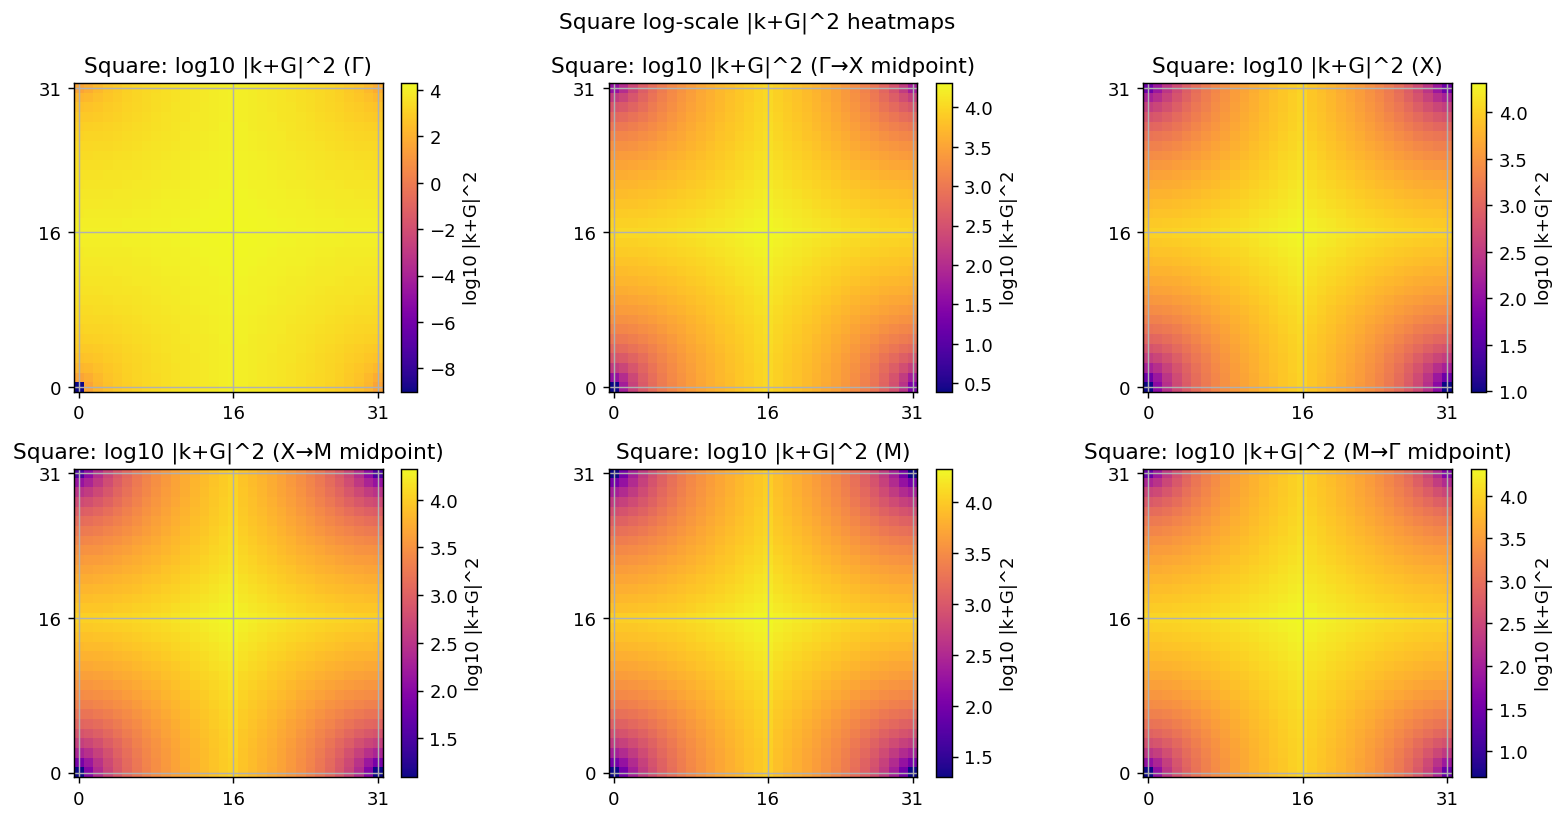

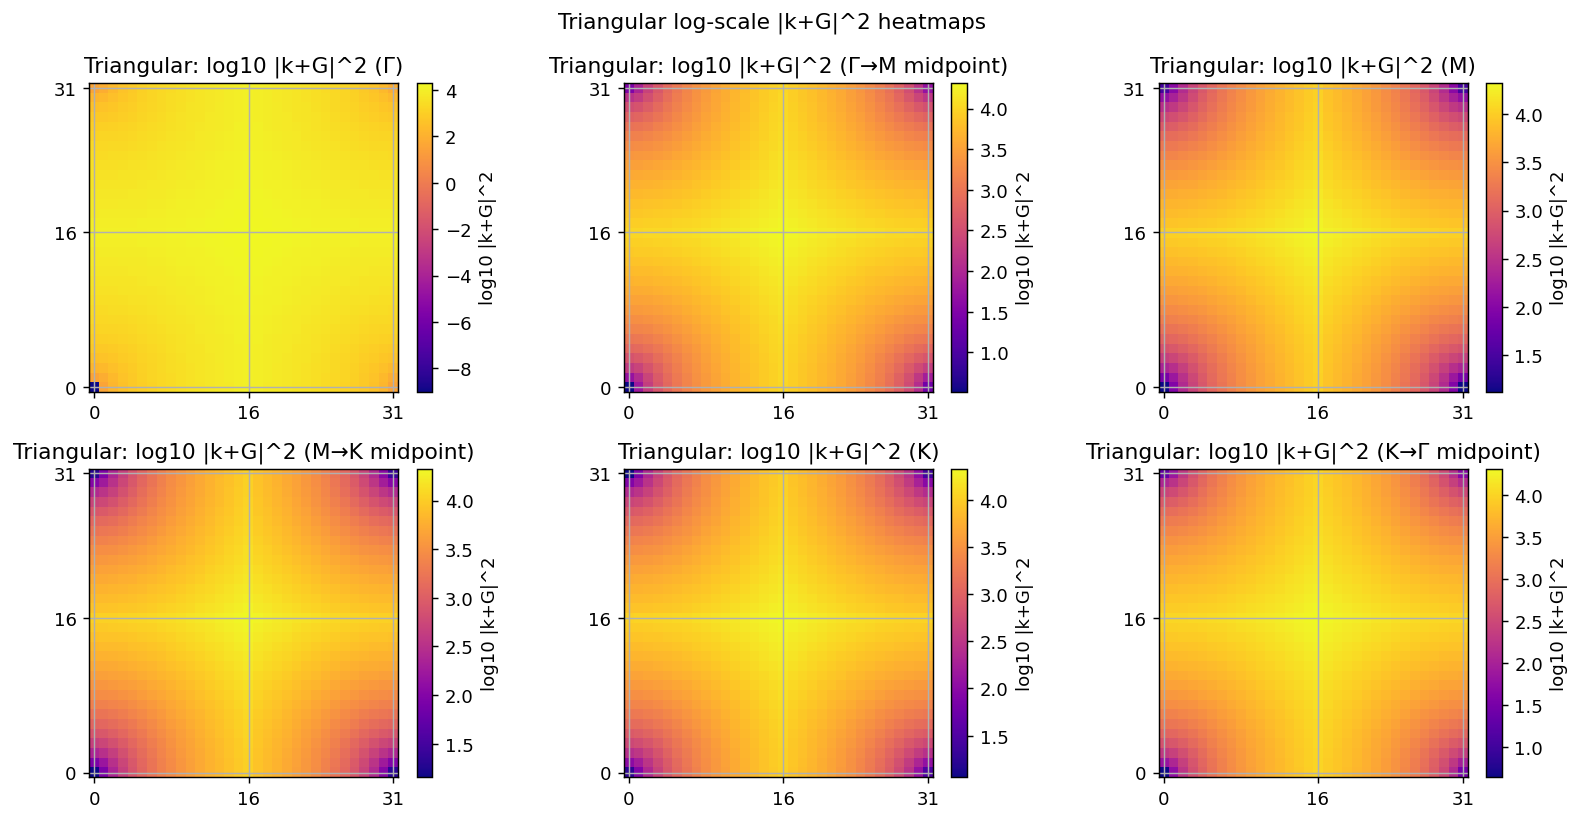

In [12]:
def plot_log_heatmaps(report: dict, lattice_label: str) -> None:
    nx, ny = report["grid"]["shape"]
    samples = report["samples"][:-1]
    rows, cols = 2, 3
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4.2, rows * 3.2))
    axes_flat = axes.flatten()
    for sample, ax in zip(samples, axes_flat):
        field = np.array(sample["k_plus_g_sq"]).reshape(ny, nx)
        field = np.maximum(field, 1e-12)
        im = ax.imshow(np.log10(field), origin="lower", cmap="plasma")
        ax.set_title(f"{lattice_label}: log10 |k+G|^2 ({sample['label']})")
        ax.set_xticks([0, nx // 2, nx - 1])
        ax.set_yticks([0, ny // 2, ny - 1])
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="log10 |k+G|^2")
    for ax in axes_flat[len(samples):]:
        ax.set_visible(False)
    fig.suptitle(f"{lattice_label} log-scale |k+G|^2 heatmaps")
    fig.tight_layout()

plot_log_heatmaps(reports["square_res32_mesh4"], "Square")
plot_log_heatmaps(reports["triangular_res32_mesh4"], "Triangular")

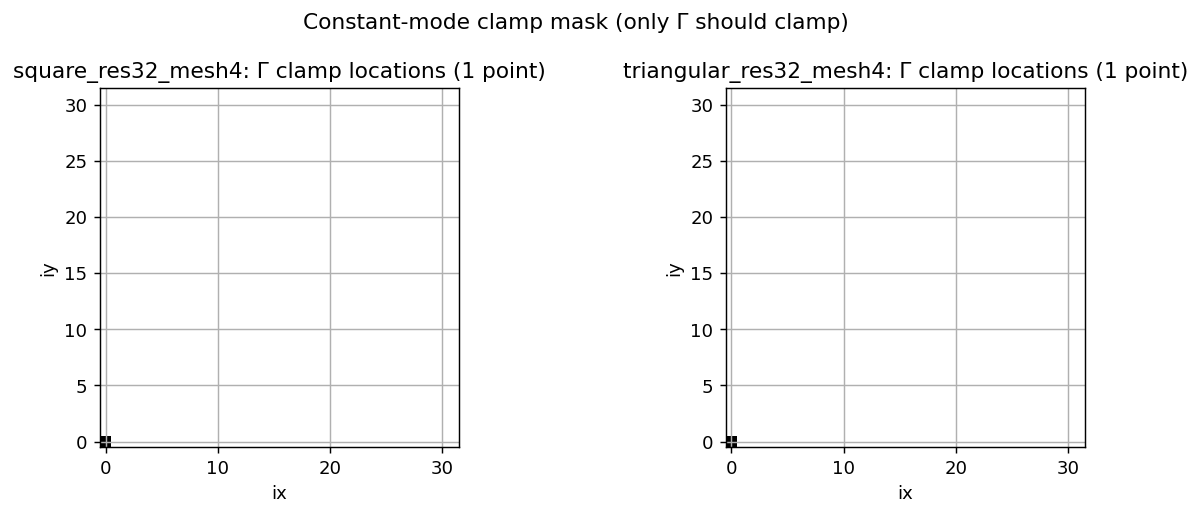

In [10]:
fig, axes = plt.subplots(1, len(reports), figsize=(5 * len(reports), 4))
if len(reports) == 1:
    axes = [axes]
for ax, (name, report) in zip(axes, reports.items()):
    sample = next(s for s in report["samples"] if s["label"] == "Γ")
    mask = np.array(sample["clamp_mask"]).reshape(report["grid"]["shape"][1], report["grid"]["shape"][0])
    ax.imshow(mask, origin="lower", cmap="Greys")
    ax.set_title(f"{name}: Γ clamp locations ({int(mask.sum())} point)")
    ax.set_xlabel("ix")
    ax.set_ylabel("iy")
fig.suptitle("Constant-mode clamp mask (only Γ should clamp)")
fig.tight_layout()

### Notebook takeaways
- Centered FFT indices map cleanly onto reciprocal components (no mismatches detected in `index_map`).
- All seven k-samples per lattice keep |k+G|² strictly non-negative, and aliasing checks confirm the tables can be shared between TE/TM pathways without further remapping.
- Only the Γ sample triggers the near-zero clamp (single pixel), matching the expected constant-mode deflation behavior; histograms stay well behaved along each symmetry leg.